In [1]:
import pandas as pd
from pyproj import Transformer
import shapely
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import *
from dash import Dash, html, dcc, Input, Output, dash_table
import dash_bootstrap_components as dbc
from dash.dependencies import State
import plotly.express as px
import pandas as pd
import geojson
import numpy as np
import plotly.graph_objects as go
import psycopg2
from psycopg2 import sql
import psycopg2.extras
import geopandas as gpd
import json
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

In [2]:
df_amoen = pd.read_excel(r"C:\Users\denis.iglesias\OneDrive - HESSO\01 Institution\02 Projets\12 AMOén\03 Projets\Suivi_projets_AMOen_dernier.xlsx",sheet_name="Vue ensemble")
df_amoen = df_amoen.dropna(subset=['Nom_projet'])
dropdown_projet = [{"label": val, "value": val} for val in df_amoen['Nom_projet'].unique() if val is not None]

In [3]:
# préparer df pour stacked bar
df_analyse_stacked = df_amoen
df_analyse_stacked = df_analyse_stacked[['statut',
                                        'Nom_projet',
                                         'Ef,obj*fp (Objectif en EF pondérée après) [MJ/m²]',
                                         'Ef,après,corr*fp (Conso. mesurée après) [MJ/m²]',
                                         ]]
df_analyse_stacked = df_analyse_stacked.groupby(['statut']).count()
df_analyse_stacked = df_analyse_stacked.reset_index()
# Objectif fixé / Réception d'index
df_analyse_stacked = df_analyse_stacked.rename(columns={'Ef,obj*fp (Objectif en EF pondérée après) [MJ/m²]': 'Objectif fixé',
                                                        'Ef,après,corr*fp (Conso. mesurée après) [MJ/m²]': 'Réception d\'index'})
df_analyse_stacked['Objectif fixé'] = df_analyse_stacked['Objectif fixé'] - df_analyse_stacked['Réception d\'index']
# Finalisé
df_analyse_stacked["Finalisé"] = df_analyse_stacked[df_analyse_stacked["statut"] == "Terminé"]['Nom_projet']
df_analyse_stacked["Finalisé"] = df_analyse_stacked["Finalisé"].fillna(0)
df_analyse_stacked["Finalisé"] = df_analyse_stacked["Finalisé"].astype(int)
df_analyse_stacked.loc[df_analyse_stacked["statut"] == "Terminé", 'Objectif fixé'] = 0
df_analyse_stacked.loc[df_analyse_stacked["statut"] == "Terminé", 'Réception d\'index'] = 0
# Pas d'objectif fixé
df_analyse_stacked["Pas d'objectif fixé"] = df_analyse_stacked['Nom_projet'] - \
                                            df_analyse_stacked['Objectif fixé'] - \
                                            df_analyse_stacked['Réception d\'index'] - \
                                            df_analyse_stacked['Finalisé']
df_analyse_stacked["Pas d'objectif fixé"] = df_analyse_stacked["Pas d'objectif fixé"].fillna(0)
df_analyse_stacked["Pas d'objectif fixé"] = df_analyse_stacked["Pas d'objectif fixé"].astype(int)
#df_analyse_stacked = df_analyse_stacked.drop(columns=['Nom_projet'])
df_analyse_stacked['total'] = df_analyse_stacked['Objectif fixé'] + df_analyse_stacked['Réception d\'index'] + df_analyse_stacked["Pas d'objectif fixé"] + df_analyse_stacked["Finalisé"]
# add in column status at the end a row total that sums all the values
df_analyse_stacked = df_analyse_stacked[['statut','Pas d\'objectif fixé','Objectif fixé', 'Réception d\'index', 'Finalisé']] #,'total','Nom_projet'
# changer ordre des statuts
# https://stackoverflow.com/questions/57161380/changing-row-order-in-pandas-dataframe-without-losing-or-messing-up-data
cats = ['Etude', "Demande d’autorisation", "En travaux", "En exploitation","Terminé"]
df_analyse_stacked['statut'] = pd.CategoricalIndex(df_analyse_stacked['statut'], ordered=True, categories=cats)
df_analyse_stacked = df_analyse_stacked.sort_values('statut')
# replace in column statut the value Terminé by Finalisé
df_analyse_stacked['statut'] = df_analyse_stacked['statut'].replace('Demande d’autorisation', 'Autor.')
df_analyse_stacked['statut'] = df_analyse_stacked['statut'].replace('En travaux', 'Travaux')
df_analyse_stacked['statut'] = df_analyse_stacked['statut'].replace('En exploitation', 'Exploit.')
# reset index
df_analyse_stacked = df_analyse_stacked.reset_index(drop=True)

In [4]:
df_analyse_stacked

,statut,Pas d'objectif fixé,Objectif fixé,Réception d'index,Finalisé
0,Etude,5,2,0,0
1,Autor.,5,4,0,0
2,Travaux,2,5,0,0
3,Exploit.,1,4,8,0
4,Terminé,0,0,0,3
5,NaN,1,0,0,0


In [5]:
bars = []

for col in df_analyse_stacked.columns[1:]:    # Iterate over all columns except 'statut'
    serie = df_analyse_stacked[col]
    bars.append(go.Bar(name=col, x=df_analyse_stacked['statut'] , y=serie, 
                       text=serie,   # display the serie value as hover text 
                       textposition='auto',   # automate the position
                       hoverinfo='name+x+text'))    # decide what info appears on hover

layout_bar_stacked = go.Layout(
    barmode='stack', 
    xaxis=dict(title='Statut'),
    yaxis=dict(title='Nombre de projets'),
)

fig_bars_stacked = go.Figure(data=bars, layout=layout_bar_stacked)
fig_bars_stacked.update_layout(
    barmode="stack",
    title="Statut des projets AMOén"  # set your title here
)

fig_bars_stacked.show()

In [6]:
df_analyse_bars = df_amoen[['Nom_projet','statut',
                         'Ef,avant,corr (IDC_avant) [MJ/m²]',
                         'Ef,obj*fp (Objectif en EF pondérée après) [MJ/m²]',
                         'Ef,après,corr*fp (Conso. mesurée après) [MJ/m²]',
                         'Part atteinte des objectifs [%]']].copy()
df_analyse_bars['Baisse IDC visée'] = df_analyse_bars.loc[:, 'Ef,avant,corr (IDC_avant) [MJ/m²]'] - \
                                        df_analyse_bars.loc[:, 'Ef,obj*fp (Objectif en EF pondérée après) [MJ/m²]']
df_analyse_bars['Baisse IDC réalisée'] = df_analyse_bars.loc[:, 'Ef,avant,corr (IDC_avant) [MJ/m²]'] - \
                                            df_analyse_bars.loc[:, 'Ef,après,corr*fp (Conso. mesurée après) [MJ/m²]']

df_analyse_bars.rename(columns={'Ef,avant,corr (IDC_avant) [MJ/m²]': 'IDC moy 3 ans avant\n$IDC_{moy3ans}$',
                                'Ef,obj*fp (Objectif en EF pondérée après) [MJ/m²]': 'Objectif\n$E_{f,obj}*f_{p}$',
                                'Ef,après,corr*fp (Conso. mesurée après) [MJ/m²]': 'Conso mesurée après\n$E_{f,après,corr}*f_{p}$'
                                },
                                inplace=True)
df_analyse_bars_exploitation = df_analyse_bars.loc[(df_analyse_bars['statut'] == 'En exploitation') &
                                                    (df_analyse_bars['Conso mesurée après\n$E_{f,après,corr}*f_{p}$'] > 0)]

In [7]:
site

NameError: name 'site' is not defined

In [9]:
from graphics.performance_par_site import performance_par_site

site = "Prulay 43 à 47_Batineg"
site1 = "Valais 7-11"
sauvegarde_png, bar_data, bar_data1, bar_data2, perf_atteinte  = performance_par_site(df_amoen, site)

display(bar_data)
display(bar_data1)
display(bar_data2)
display(perf_atteinte)



c:\Users\denis.iglesias\Documents\GitHub\Project_VI_IDC\graphics\performance_par_site.py:79: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




,Nom_projet,Type,Valeur
0,Prulay 43 à 47_Batineg,IDC moy 3 ans avant\n$IDC_{moy3ans}$,449.000
1,Prulay 43 à 47_Batineg,"Objectif\n$E_{f,obj}*f_{p}$",250.900
2,Prulay 43 à 47_Batineg,"Conso mesurée après\n$E_{f,après,corr}*f_{p}$",247.900
3,Prulay 43 à 47_Batineg,Part atteinte des objectifs [%],1.015
4,Prulay 43 à 47_Batineg,Baisse IDC visée,198.100
5,Prulay 43 à 47_Batineg,Baisse IDC réalisée,201.100


,Nom_projet,Type,Valeur
0,Prulay 43 à 47_Batineg,IDC moy 3 ans avant\n$IDC_{moy3ans}$,449.0
1,Prulay 43 à 47_Batineg,"Objectif\n$E_{f,obj}*f_{p}$",250.9
2,Prulay 43 à 47_Batineg,"Conso mesurée après\n$E_{f,après,corr}*f_{p}$",247.9


,Nom_projet,Type,Valeur
3,Prulay 43 à 47_Batineg,Part atteinte des objectifs [%],1.015


101

,Nom_projet,Type,Valeur


,Nom_projet,Type,Valeur


,Nom_projet,Type,Valeur


C:\Users\denis.iglesias\AppData\Local\Temp\ipykernel_38068\3494696881.py:68: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\denis.iglesias\AppData\Local\Temp\ipykernel_38068\3494696881.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\denis.iglesias\AppData\Local\Temp\ipykernel_38068\3494696881.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\denis.iglesias\AppData\Local\Temp\ipykernel_38068\3494696881.

IndexError: list index out of range

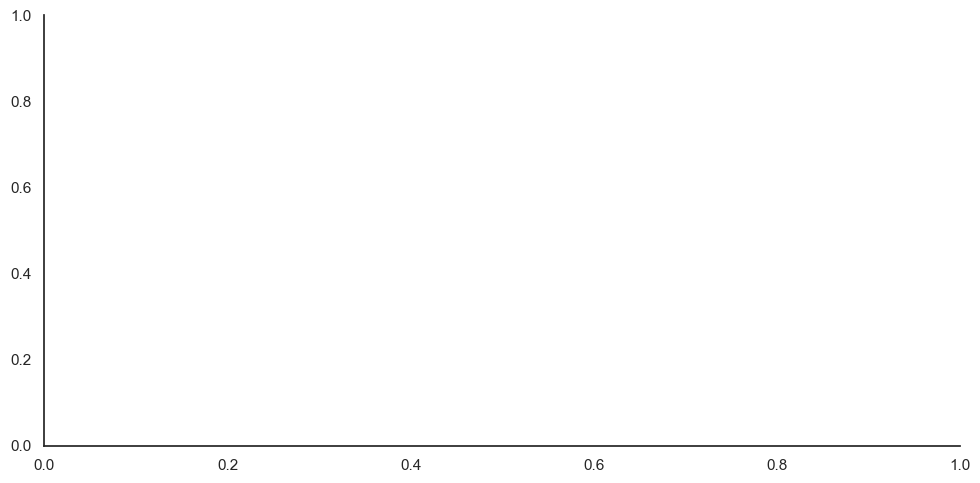

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import PureWindowsPath
import numpy as np
import seaborn as sns
from datetime import datetime
import os
from datetime import date

site = "Valais 7-11"

now = datetime.now()
date_png = str(now.strftime("%Y-%m-%d"))
date_titre = str(now.strftime("%d-%m-%Y"))
# Create a new directory with the current date as its name
today = date.today()
directory = os.path.join('01_graphiques\\01_performance_par_site\\', today.strftime("%Y-%m-%d"))
if not os.path.exists(directory):
    os.makedirs(directory)

df_analyse_bars = df_amoen[['Nom_projet','statut',
                        'Ef,avant,corr (IDC_avant) [MJ/m²]',
                        'Ef,obj*fp (Objectif en EF pondérée après) [MJ/m²]',
                        'Ef,après,corr*fp (Conso. mesurée après) [MJ/m²]',
                        'Part atteinte des objectifs [%]']].copy()
df_analyse_bars['Baisse IDC visée'] = df_analyse_bars.loc[:, 'Ef,avant,corr (IDC_avant) [MJ/m²]'] - \
                                        df_analyse_bars.loc[:, 'Ef,obj*fp (Objectif en EF pondérée après) [MJ/m²]']
df_analyse_bars['Baisse IDC réalisée'] = df_analyse_bars.loc[:, 'Ef,avant,corr (IDC_avant) [MJ/m²]'] - \
                                            df_analyse_bars.loc[:, 'Ef,après,corr*fp (Conso. mesurée après) [MJ/m²]']

df_analyse_bars.rename(columns={'Ef,avant,corr (IDC_avant) [MJ/m²]': 'IDC moy 3 ans avant\n$IDC_{moy3ans}$',
                                'Ef,obj*fp (Objectif en EF pondérée après) [MJ/m²]': 'Objectif\n$E_{f,obj}*f_{p}$',
                                'Ef,après,corr*fp (Conso. mesurée après) [MJ/m²]': 'Conso mesurée après\n$E_{f,après,corr}*f_{p}$'
                                },
                                inplace=True)

#sauvegarde_png = PureWindowsPath (r"01_graphiques\\01_performance_par_site\\03_bars_par_site_" + site + '-' + date_png + '.png')
sauvegarde_png = os.path.join(directory, "01_performance_par_site_" + site + '-' + date_png + '.png')

display(bar_data)

# filtrer les données selon besoins
bar_data = df_analyse_bars[df_analyse_bars['Nom_projet'] == site]
bar_data = bar_data.drop(columns=['statut'])

# stack pour adapter les données pour le graphique
# https://stackoverflow.com/questions/66998010/how-to-pivot-from-columns-to-rows-in-pandas
bar_data = bar_data.set_index (['Nom_projet'])
bar_data = bar_data.stack().rename_axis (['Nom_projet','Type']).reset_index()
bar_data.rename(columns={0: 'Valeur'},inplace=True)

# Séparer les données pour le graphique
bar_data1 = bar_data[(bar_data['Type'] != 'Part atteinte des objectifs [%]')]
bar_data1 = bar_data1[(bar_data1['Type'] != 'Baisse IDC réalisée')]
bar_data1 = bar_data1[(bar_data1['Type'] != 'Baisse IDC visée')]

bar_data2 = bar_data[(bar_data['Type'] == 'Part atteinte des objectifs [%]')]

bar_data.sort_values (by=['Type'])



# https://stackoverflow.com/questions/21923524/extracting-single-value-from-column-in-pandas
perf_atteinte = bar_data2['Valeur'].values[bar_data2['Type'] == 'Part atteinte des objectifs [%]']
try:
    perf_atteinte = int(perf_atteinte * 100)
except TypeError:
    bar_data['Valeur'][2] = 0
    bar_data['Valeur'][3] = 0
    bar_data['Valeur'][5] = 0

    bar_data1['Valeur'][2] = 0

    bar_data2['Valeur'][0] = 0

# taille graphique 16/9 avec les bords adapté page word paysage

# Générer histogramme. taillebin est utilisé pour uniformiser le format de l'histogramme et que les axes
# correspondent bien à la largeur des barres (bin)
cm = 1 / 2.54
sns.set (style='white',rc={"figure.figsize":(30* cm, 14.2 * cm)})
# ax1 = sns.catplot(x='Nom_projet', y='Valeur', hue='Type', kind='bar', data=bar_data1)

ax = sns.barplot (y="Valeur",
                    x="Type",
                    data=bar_data1,
                    order=['IDC moy 3 ans avant\n$IDC_{moy3ans}$',"Objectif\n$E_{f,obj}*f_{p}$",'Conso mesurée après\n$E_{f,après,corr}*f_{p}$'],
                    palette="pastel",
                    legend=False)

sns.despine()

ax.bar_label (ax.containers[0])

height_line85 = bar_data['Valeur'][0] - bar_data['Valeur'][4]*0.85
text_line85 = '$(E_{f,après,corr}*f_{p})_{max→subv.}=$' + '$' + str(np.round(bar_data['Valeur'][0] - bar_data['Valeur'][4]*0.85, 1)) + ' {MJ/m}^2$'
ax.axhline (height_line85, xmin=0.445, xmax=0.98, color='indigo', linestyle=(0, (5, 10)), linewidth=0.7)
# Add text near the line.
offset_85 = 1
ax.annotate(text_line85, xy=(2, height_line85 + offset_85), xytext=(1.57, height_line85 + offset_85),
            horizontalalignment='right', verticalalignment='bottom', fontsize=10, color='indigo')

####################

# première flèche
# find the height of the first and third bars
first_bar_height = bar_data['Valeur'][bar_data['Type'] == 'IDC moy 3 ans avant\n$IDC_{moy3ans}$'].values[0]
second_bar_height = bar_data['Valeur'][bar_data['Type'] == 'Objectif\n$E_{f,obj}*f_{p}$'].values[0]
# set the x-coordinate for the third bar
x_coord_second_bar = 0.8  # this depends on the actual x-coordinate of the third bar
# text for the arrow
text_arrow_baisse_realisee = "Baisse\nobjectif\n"+str('{:.1f}'.format(bar_data['Valeur'][4])) + " MJ/m²"
# add text at the midpoint of the arrow
midpoint_height = (first_bar_height + second_bar_height) / 2
# plot the line (arrow without arrowheads)
ax.annotate("", xy=(x_coord_second_bar, second_bar_height), xytext=(x_coord_second_bar, first_bar_height),
            arrowprops=dict(arrowstyle="<->", color='moccasin', lw=3))  # increase lw for a thicker line
# add the text over the line and centered
u = ax.text(x_coord_second_bar, midpoint_height, text_arrow_baisse_realisee, ha='center', va='center', rotation=0,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="white", lw=2))

# deuxième flèche
# find the height of the first and third bars
third_bar_height = bar_data['Valeur'][bar_data['Type'] == 'Conso mesurée après\n$E_{f,après,corr}*f_{p}$'].values[0]
# set the x-coordinate for the third bar
x_coord_third_bar = 1.8  # this depends on the actual x-coordinate of the third bar
# text for the arrow
text_arrow_baisse_realisee = "Baisse\nmesurée\n"+str('{:.1f}'.format(bar_data['Valeur'][5])) + " MJ/m²"
# add text at the midpoint of the arrow
midpoint_height = (first_bar_height + third_bar_height) / 2
# plot the line (arrow without arrowheads)
ax.annotate("", xy=(x_coord_third_bar, third_bar_height), xytext=(x_coord_third_bar, first_bar_height),
            arrowprops=dict(arrowstyle="->", color='lightgreen', lw=4))  # increase lw for a thicker line
# add the text over the line and centered
u = ax.text(x_coord_third_bar, midpoint_height, text_arrow_baisse_realisee, ha='center', va='center', rotation=0,
        bbox=dict(boxstyle="round,pad=0.3", fc="lime", ec="lime", lw=2))

#####################
# titres
# titre de l'histogramme
title_text = str('{:.1f}'.format(bar_data['Valeur'][3]*100)) + "% de l'objectif atteint"
title_color = 'darkgreen' if bar_data['Valeur'][3]*100 >= 85 else 'red'

plt.title(title_text, weight='bold', color=title_color, loc='center', pad=15, fontsize=14, y=0.925)

# sous-titre
plt.suptitle(site, fontsize=16, x=0.515, y=0.99)
# Modifier l'espacement entre sous-titre et titre
plt.subplots_adjust (top=.945, bottom=.17, left=.06, right=.97, hspace=.2, wspace=.2)

# date de génération du graphique
now = datetime.now()
date_str = str(now.strftime("%d-%m-%Y"))
ax.text(1.0, -0.24, date_str, transform=ax.transAxes,
    ha='right', va='bottom', fontsize=8)

# titre pour l'abscisse X
plt.xlabel("\nBaisse d'IDC minimum pour obtenir la subvention = 85% * " +
            str('{:.1f}'.format(bar_data['Valeur'][4])) + " = " +
            str('{:.1f}'.format(bar_data['Valeur'][4]*0.85)) + ' MJ/m² \n$E_{f,après,corr}*f_{p}$ maximum pour obtenir la subvention ($(E_{f,après,corr}*f_{p})_{max→subv.}$) = ' +
            str('{:.1f}'.format(bar_data['Valeur'][0])) + " - " +
            str('{:.1f}'.format(bar_data['Valeur'][4]*0.85)) + " = " +
            str('{:.1f}'.format(bar_data['Valeur'][0] - bar_data['Valeur'][4]*0.85)) + " MJ/m²\nPourcentage de l'objectif atteint = " +
            str('{:.1f}'.format(bar_data['Valeur'][5])) + " / " + 
            str('{:.1f}'.format(bar_data['Valeur'][4]))+ " * 100 = " +
            str('{:.1f}'.format(bar_data['Valeur'][5]/bar_data['Valeur'][4]*100)) + "%", 
            loc='left', size=9)
# titre pour l'ordonnée Y
plt.ylabel("[MJ/m²/an]")


# sauvegarder graphique
#plt.savefig (sauvegarde_png,dpi=600)


# nettoyage
plt.close()